In [30]:
#!pip install -q numpy==1.26.4

In [103]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
import torch
import torch.nn as nn
import torch.nn.functional as F
import optuna
import lightgbm as lgb
import shap
import gc

from typing import Optional, List, Callable, Union
from sqlalchemy.engine import Engine
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from phik import phik_matrix
from sqlalchemy import create_engine

In [32]:
warnings.filterwarnings('ignore')

In [33]:
RANDOM_STATE = 0
TEST_SIZE = 0.2
torch.manual_seed(RANDOM_STATE)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [34]:
print(torch.cuda.is_available())

True


In [35]:
def connect_to_db() -> Optional[Engine]:
    try:
        db_config = {
            'user': 'praktikum_student',
            'pwd': 'Sdf4$2;d-d30pp', 
            'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
            'port': 6432,
            'db': 'data-science-vehicle-db'
        } 
        connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
            db_config['user'],
            db_config['pwd'],
            db_config['host'],
            db_config['port'],
            db_config['db']
        )
        return create_engine(connection_string)
    
    except Exception as e:
        print(f'Error: {e}')
        return None


In [36]:
def get_any_data(query: str) -> Optional[pd.DataFrame]:
    try:
        engine = connect_to_db()
        
        get_query = query
        return pd.read_sql_query(get_query, con=engine)
    
    except Exception as e:
        print(f'Error: {e}')
        return None

In [37]:
def get_main_data() -> Optional[pd.DataFrame]:
    try:
        engine = connect_to_db()
        
        query = '''
            SELECT
                c.*,
                p.party_number, p.at_fault, p.insurance_premium, p.party_sobriety, p.party_drug_physical, p.cellphone_in_use,
                v.vehicle_type, v.vehicle_transmission, v.vehicle_age
            FROM
                collisions c
            INNER JOIN
                parties p ON c.case_id = p.case_id
            INNER JOIN
                vehicles v ON c.case_id = v.case_id
            WHERE
                c.collision_date BETWEEN '2012-01-01' AND '2012-12-31'
                AND c.collision_damage != 'scratch'
                AND p.party_type = 'car';
        '''
        return pd.read_sql_query(query, con=engine)
    except Exception as e:
        print(f'Error: {e}')
        return None

In [38]:
def get_data() -> Optional[pd.DataFrame]:
    try:
        engine = connect_to_db()

        query = '''
            SELECT 
                v.party_number, v.vehicle_type, v.vehicle_transmission, v.vehicle_age,
                c.collision_date, c.case_id
            FROM vehicles v
            JOIN collisions c ON v.case_id = c.case_id
            JOIN parties p ON v.case_id = p.case_id
            WHERE 
                c.collision_date BETWEEN '2012-01-01' AND '2012-12-31'
                AND c.collision_damage != 'scratch'
                AND p.party_type = 'car';

        '''
        data = pd.read_sql_query(query, con=engine)
        data.collision_date = pd.to_datetime(data.collision_date)
        data['month'] = data.collision_date.dt.month
        data.vehicle_age = data.vehicle_age.fillna(-1).astype('int')
        return data
    except Exception as e:
        print(f'Error: {e}')
        return None

In [39]:
def pie_chart(data: pd.DataFrame, 
              column: str, 
              **kwargs) -> None:
    data[column].value_counts().plot(
        kind='pie',
        figsize=(10,10),
        autopct='%1.1f%%',
        wedgeprops={'width':0.5},
        ylabel='',
        **kwargs
    )
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1.3, 1), loc='upper right', fontsize=11)
    plt.show()

In [40]:
def line_chart(data: pd.DataFrame, 
               index: Union[str, List[str]], 
               values: Union[str, List[str]], 
               aggfunc: Union[str, Callable], 
               **kwargs) -> None:
    data.pivot_table(
        index=index,
        values=values,
        aggfunc=aggfunc).plot(     
            style='o-',
            figsize=(15, 6),
            markerfacecolor='blue',
            markeredgecolor='black',
            markersize=8,
            linewidth=2,
            fontsize=14,
            **kwargs
        )
    
    plt.legend(loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [41]:
def bar_chart(data, column, **kwargs) -> None:
    data[column].value_counts().plot(
        kind='bar',
        figsize=(11,7),
        color='#BA55D3',
        **kwargs
    )
    plt.legend()
    plt.show()

In [42]:
data = get_main_data()
analyze_data = get_data()

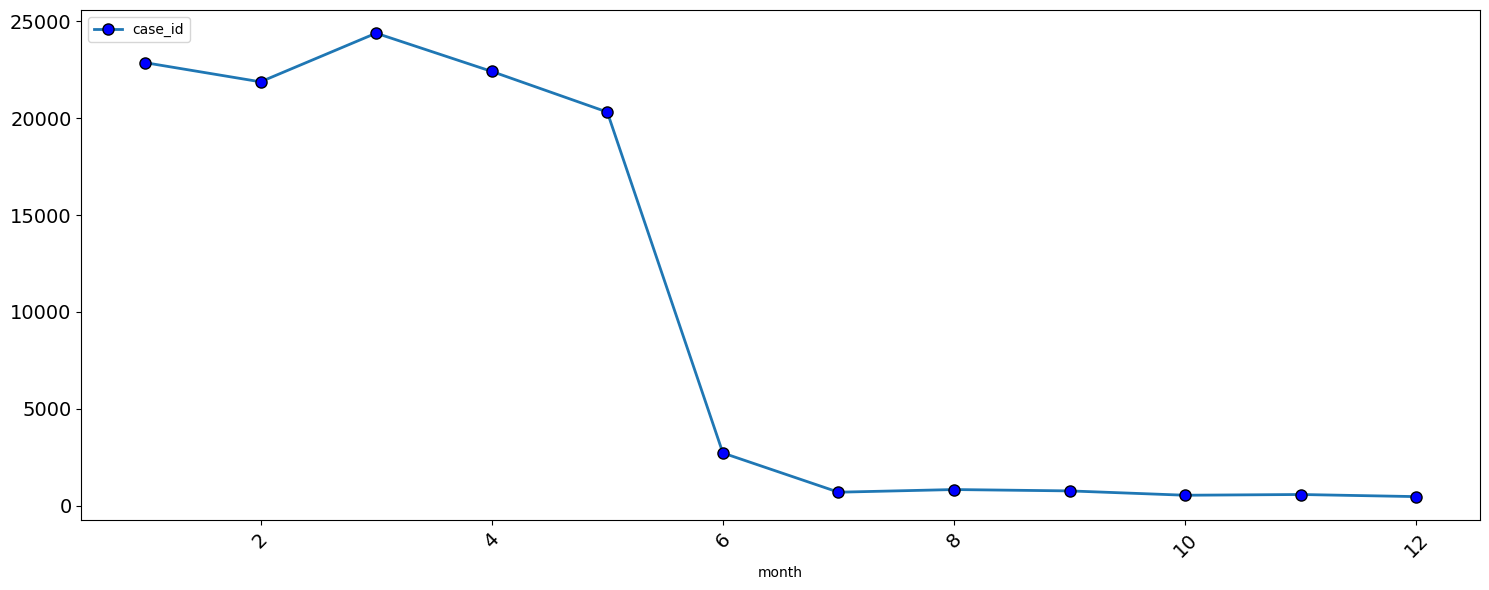

In [43]:
line_chart(analyze_data, 'month', 'case_id', 'count')

## ШАГ 3 ЗАДАНИЕ 2

Задачи для коллег 

    Аналитические задачи для коллег:

        Проанализировать использование телефона за рулем и погодные условия
        Цель: определить, при каких условиях чаще происходят аварии

        Исследовать связь времени суток с тяжестью повреждений
        Цель: выявить периоды с наиболее серьёзными последствиями

        Определить, как возраст водителя влияет на вероятность ДТП
        Цель: найти возрастные группы с повышенным риском

        Изучить распределение ДТП по типам дорожного покрытия
        Цель: выявить опасные типы дорог

        Проанализировать связь между скоростным режимом на участке и количеством ДТП
        Цель: определить, как скорость влияет на аварийность

        Оценить влияние освещения дороги на частоту ДТП в ночное время
        Цель: проверить, снижает ли освещение риски

Решение задачи 1 - 'Проанализировать влияние погодных условий на частоту ДТП'

### Решение первой задачи

In [44]:
query_task1 = '''
    SELECT 
        c.weather_1,
        p.cellphone_in_use
    FROM collisions c
    JOIN parties p ON c.case_id = p.case_id
    WHERE 
        c.collision_date BETWEEN '2012-01-01' AND '2012-12-31'
        AND c.collision_damage != 'scratch'
        AND p.party_type = 'car'
        AND p.at_fault = 1
        AND c.weather_1 IS NOT NULL
        AND p.cellphone_in_use IS NOT NULL
        AND p.cellphone_in_use = 1;
'''
task1 = get_any_data(query_task1)

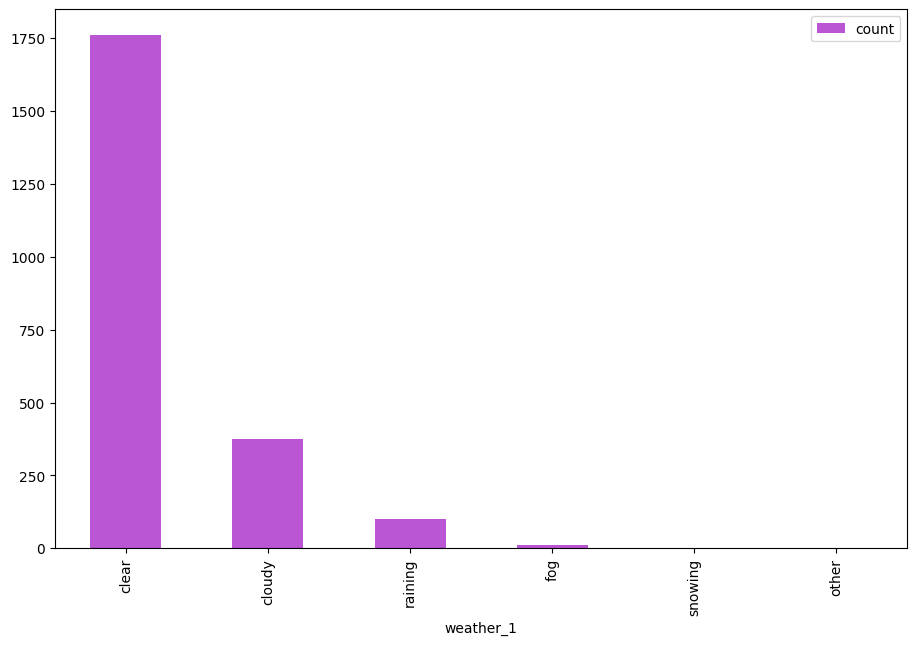

In [45]:
bar_chart(task1, 'weather_1')

### Решение второй задачи

In [46]:
# query_task2 = '''
#     SELECT 
#         c.weather_1,
#         p.cellphone_in_use
#     FROM collisions c
#     JOIN parties p ON c.case_id = p.case_id
#     WHERE 
#         c.collision_date BETWEEN '2012-01-01' AND '2012-12-31'
#         AND c.collision_damage != 'scratch'
#         AND p.party_type = 'car'
#         AND p.at_fault = 1
#         AND c.weather_1 IS NOT NULL
#         AND p.cellphone_in_use IS NOT NULL
#         AND p.cellphone_in_use = 1;
# '''
# task2 = get_any_data(query_task2)

In [47]:
# bar_chart(task1, 'weather_1')

## Предобработка

In [48]:
data = data.drop_duplicates()
data.case_id = data.case_id.astype('int')
data = data[data['distance'] < 4000.0]
data.direction = data.direction.fillna('unknown').astype('category')
data.intersection = data.intersection.apply(lambda x: 'Y' if x == 1. else 
                                                      'N' if x == 0 else x).fillna('unknown').astype('category')
data.weather_1 = data.weather_1.fillna('unknown').astype('category')
data.location_type = data.location_type.fillna('unknown').astype('category')
data.collision_damage = data.collision_damage.astype('category')
data.party_count = data.party_count.apply(lambda x: '5+' if x > 4 else x).apply(
    lambda x: 'one' if x == 1 else
              'two' if x == 2 else
              'three' if x == 3 else
              'four' if x == 4 else
              'five_plus' if str(x) == '5+' else x).astype('category')
data.primary_collision_factor = data.primary_collision_factor.fillna('unknown').astype('category')
data.pcf_violation_category = data.pcf_violation_category.fillna('unknown').astype('category')
data.type_of_collision = data.type_of_collision.fillna('other').astype('category')
data.motor_vehicle_involved_with = data.motor_vehicle_involved_with.fillna('unknown').astype('category')
data.road_surface = data.road_surface.fillna('unknown').astype('category')
data.road_condition_1 = data.road_condition_1.fillna('other').astype('category')
data.lighting = data.lighting.fillna('unknown').astype('category')
data.control_device = data.control_device.fillna('unknown').astype('category')
data.collision_date = pd.to_datetime(data.collision_date)
data['collision_month'] = data.collision_date.dt.month
data['collision_day'] = data.collision_date.dt.day
data.collision_time = pd.to_datetime(data.collision_time, format='%H:%M:%S')
data['collision_hour'] = data.collision_time.dt.hour
data.party_number = data.party_number.apply(lambda x: '5+' if x > 4 else x).apply(
    lambda x: 'one' if x == 1 else
              'two' if x == 2 else
              'three' if x == 3 else
              'four' if x == 4 else
              'five_plus' if str(x) == '5+' else x).astype('category')
data.at_fault = data.at_fault.astype('category')
data.party_sobriety = data.party_sobriety.fillna('unknown').astype('category')
data.party_drug_physical = data.party_drug_physical.fillna('unknown').astype('category')
data.cellphone_in_use = data.cellphone_in_use.fillna('3.0').apply(
    lambda x: 'no' if x == 0 else
              'yes' if x == 1 else
              'unknown' if x == 3 else x).astype('category')
data.vehicle_type = data.vehicle_type.astype('category')
data.vehicle_transmission = data.vehicle_transmission.fillna('unknown').astype('category')
data = data[data['vehicle_age'] < 161.0]
data['insurance_premium'] = data['insurance_premium'].fillna(-1)
data['collision_hour'] = data['collision_hour'].interpolate()
data.at_fault = data.at_fault.astype('int')


In [49]:
# report = sv.analyze(data)
# report.show_notebook()

## Шаг 4. Создание моделей для оценки водительского риска

### Подготовка данных для моделей

In [50]:
# plt.figure(figsize=(15, 13))
# sns.heatmap(phik_matrix(data[[
#     'county_location',
#     'intersection',
#     'weather_1',
#     'location_type',
#     'collision_damage',
#     'party_count',
#     'primary_collision_factor',
#     'pcf_violation_category',
#     'type_of_collision',
#     'motor_vehicle_involved_with',
#     'road_surface',
#     'road_condition_1',
#     'lighting',
#     'control_device',
#     'party_number',
#     'at_fault',
#     'party_sobriety',
#     'party_drug_physical',
#     'cellphone_in_use',
#     'vehicle_transmission',
# ]], interval_cols=['distance', 'insurance_premium', 'vehicle_age', 'collision_month', 'collision_day', 'collision_hour']), annot=True, cmap='coolwarm')
# plt.show()

In [101]:
num_cols = [
    'distance', 
    'insurance_premium', 
    'vehicle_age', 
    'collision_month', 
    'collision_day', 
    'collision_hour'
]
cat_cols = [
    'county_location',
    'intersection',
    'weather_1',
    'location_type',
    'collision_damage',
    'party_count',
    'primary_collision_factor',
    'pcf_violation_category',
    'type_of_collision',
    'motor_vehicle_involved_with',
    'road_surface',
    'road_condition_1',
    'lighting',
    'control_device',
    'party_number',
    'party_sobriety',
    'party_drug_physical',
    'cellphone_in_use',
    'vehicle_transmission'
]
all_cols = num_cols + cat_cols

In [ ]:
X = data[all_cols]
y = data.at_fault

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=y)

In [53]:
def data_preporation(
        numeric_cols: List[str] = num_cols,
        category_cols: List[str] = cat_cols,
        X_train: pd.DataFrame = X_train,
        X_test: pd.DataFrame = X_test
) -> tuple[pd.DataFrame, pd.DataFrame]:
    
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_cols),
        ('cat', OrdinalEncoder(
            handle_unknown='use_encoded_value', 
            unknown_value=np.nan                     
        ), category_cols)
    ], remainder='passthrough')

    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    feature_names = preprocessor.get_feature_names_out()
    X_train = pd.DataFrame(X_train_processed, columns=feature_names)
    X_test = pd.DataFrame(X_test_processed, columns=feature_names)
    return X_train, X_test

X_train, X_test = data_preporation()

In [54]:
X_train_torch = torch.FloatTensor(X_train.values).to(device)
X_test_torch = torch.FloatTensor(X_test.values).to(device)
y_train_torch = torch.FloatTensor(y_train.values).to(device)
y_test_torch = torch.FloatTensor(y_test.values).to(device)

train_dataset_torch = TensorDataset(X_train_torch, y_train_torch)
test_dataset_torch = TensorDataset(X_test_torch, y_test_torch)

### Написание нейронной сети с помощью pytorch

#### Написание архитектуры

In [55]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_units, dropout_rate):
        super(Net, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(hidden_units, hidden_units//2),
            nn.BatchNorm1d(hidden_units//2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(hidden_units//2, hidden_units//4),
            nn.BatchNorm1d(hidden_units//4),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(hidden_units//4, hidden_units//8),
            nn.BatchNorm1d(hidden_units//8),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(hidden_units//8, 1),
            #nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

#### Перебор гиперпараметров с помощью оптуны

In [56]:
def objective(trial):
    params = {
        'hidden_units': trial.suggest_categorical('hidden_units', [256, 512, 1024, 2048]),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.5),
        'lr': trial.suggest_float('lr', 1e-4, 1e-2, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [64, 128, 256, 512, 1024, 2048])
    }

    print(f"\n=== Starting Trial {trial.number} ===")
    print(f"Parameters: {params}")

    train_loader = DataLoader(train_dataset_torch,
                              batch_size=params['batch_size'],
                              shuffle=True)
    
    net = Net(
        input_size=X_train.shape[1],
        hidden_units=params['hidden_units'],
        dropout_rate=params['dropout_rate']
    ).to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=params['lr'])
    loss_fn = nn.BCEWithLogitsLoss()

    best_f1 = 0
    patience = 20
    no_improve = 0
    num_epoch = 500

    for epoch in range(num_epoch):
        net.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            train_preds = net(inputs)
            train_loss = loss_fn(train_preds, labels.unsqueeze(1)) 
            train_loss.backward()
            optimizer.step()
        
        if epoch % 5 == 0 or epoch == num_epoch -1:
            net.eval()
            with torch.no_grad():
                test_inputs, test_labels = X_test_torch.to(device), y_test_torch.to(device)
                outputs = net(test_inputs)
                test_preds = (outputs > 0.5).float()
                test_f1 = f1_score(test_labels.cpu(), test_preds.cpu())
                
                if test_f1 > best_f1:
                    best_f1 = test_f1
                    no_improve = 0
                    best_epoch = epoch
                else:
                    no_improve += 1

                print(f"Trial {trial.number} | Epoch {epoch:3d} | "
                      f"Val F1: {test_f1:.4f} | Best F1: {best_f1:.4f} @ Epoch {best_epoch}")

                if no_improve >= patience:
                    print(f"Early stopping at epoch {epoch}")
                    break

            trial.report(test_f1, epoch)
            if trial.should_prune():
                print(f"Pruned trial {trial.number} at epoch {epoch}")
                raise optuna.exceptions.TrialPruned()
            
    print(f"=== Completed Trial {trial.number} | Best F1: {best_f1:.4f} ===")
    return best_f1

In [57]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

print(f'best params: {study.best_params}')
print(f'best f1: {study.best_value}')

[I 2025-02-24 19:11:27,153] A new study created in memory with name: no-name-cc2d9665-5c59-4255-afd8-92f58c9f7773



=== Starting Trial 0 ===
Parameters: {'hidden_units': 1024, 'dropout_rate': 0.19286397590071594, 'lr': 0.006865064440630252, 'batch_size': 64}
Trial 0 | Epoch   0 | Val F1: 0.9017 | Best F1: 0.9017 @ Epoch 0
Trial 0 | Epoch   5 | Val F1: 0.8974 | Best F1: 0.9017 @ Epoch 0
Trial 0 | Epoch  10 | Val F1: 0.9062 | Best F1: 0.9062 @ Epoch 10
Trial 0 | Epoch  15 | Val F1: 0.9060 | Best F1: 0.9062 @ Epoch 10
Trial 0 | Epoch  20 | Val F1: 0.9063 | Best F1: 0.9063 @ Epoch 20
Trial 0 | Epoch  25 | Val F1: 0.9062 | Best F1: 0.9063 @ Epoch 20
Trial 0 | Epoch  30 | Val F1: 0.9033 | Best F1: 0.9063 @ Epoch 20
Trial 0 | Epoch  35 | Val F1: 0.9022 | Best F1: 0.9063 @ Epoch 20
Trial 0 | Epoch  40 | Val F1: 0.9039 | Best F1: 0.9063 @ Epoch 20
Trial 0 | Epoch  45 | Val F1: 0.9041 | Best F1: 0.9063 @ Epoch 20
Trial 0 | Epoch  50 | Val F1: 0.9046 | Best F1: 0.9063 @ Epoch 20
Trial 0 | Epoch  55 | Val F1: 0.9018 | Best F1: 0.9063 @ Epoch 20
Trial 0 | Epoch  60 | Val F1: 0.9070 | Best F1: 0.9070 @ Epoch 60


[I 2025-02-24 19:20:47,900] Trial 0 finished with value: 0.9102425611312973 and parameters: {'hidden_units': 1024, 'dropout_rate': 0.19286397590071594, 'lr': 0.006865064440630252, 'batch_size': 64}. Best is trial 0 with value: 0.9102425611312973.


Trial 0 | Epoch 240 | Val F1: 0.9054 | Best F1: 0.9102 @ Epoch 140
Early stopping at epoch 240
=== Completed Trial 0 | Best F1: 0.9102 ===

=== Starting Trial 1 ===
Parameters: {'hidden_units': 512, 'dropout_rate': 0.3692859280880132, 'lr': 0.00029476959024603755, 'batch_size': 64}
Trial 1 | Epoch   0 | Val F1: 0.8894 | Best F1: 0.8894 @ Epoch 0
Trial 1 | Epoch   5 | Val F1: 0.9053 | Best F1: 0.9053 @ Epoch 5
Trial 1 | Epoch  10 | Val F1: 0.9041 | Best F1: 0.9053 @ Epoch 5
Trial 1 | Epoch  15 | Val F1: 0.9057 | Best F1: 0.9057 @ Epoch 15
Trial 1 | Epoch  20 | Val F1: 0.9063 | Best F1: 0.9063 @ Epoch 20
Trial 1 | Epoch  25 | Val F1: 0.9049 | Best F1: 0.9063 @ Epoch 20
Trial 1 | Epoch  30 | Val F1: 0.9054 | Best F1: 0.9063 @ Epoch 20
Trial 1 | Epoch  35 | Val F1: 0.9063 | Best F1: 0.9063 @ Epoch 35
Trial 1 | Epoch  40 | Val F1: 0.9041 | Best F1: 0.9063 @ Epoch 35
Trial 1 | Epoch  45 | Val F1: 0.9057 | Best F1: 0.9063 @ Epoch 35
Trial 1 | Epoch  50 | Val F1: 0.9051 | Best F1: 0.9063 @ Epo

[I 2025-02-24 19:28:15,234] Trial 1 finished with value: 0.9082550860719875 and parameters: {'hidden_units': 512, 'dropout_rate': 0.3692859280880132, 'lr': 0.00029476959024603755, 'batch_size': 64}. Best is trial 0 with value: 0.9102425611312973.


Trial 1 | Epoch 190 | Val F1: 0.9063 | Best F1: 0.9083 @ Epoch 90
Early stopping at epoch 190
=== Completed Trial 1 | Best F1: 0.9083 ===

=== Starting Trial 2 ===
Parameters: {'hidden_units': 1024, 'dropout_rate': 0.2635853285588634, 'lr': 0.00029029593790855777, 'batch_size': 64}
Trial 2 | Epoch   0 | Val F1: 0.9030 | Best F1: 0.9030 @ Epoch 0
Trial 2 | Epoch   5 | Val F1: 0.9067 | Best F1: 0.9067 @ Epoch 5
Trial 2 | Epoch  10 | Val F1: 0.9066 | Best F1: 0.9067 @ Epoch 5
Trial 2 | Epoch  15 | Val F1: 0.9074 | Best F1: 0.9074 @ Epoch 15
Trial 2 | Epoch  20 | Val F1: 0.9066 | Best F1: 0.9074 @ Epoch 15
Trial 2 | Epoch  25 | Val F1: 0.9065 | Best F1: 0.9074 @ Epoch 15
Trial 2 | Epoch  30 | Val F1: 0.9056 | Best F1: 0.9074 @ Epoch 15
Trial 2 | Epoch  35 | Val F1: 0.9062 | Best F1: 0.9074 @ Epoch 15
Trial 2 | Epoch  40 | Val F1: 0.9071 | Best F1: 0.9074 @ Epoch 15
Trial 2 | Epoch  45 | Val F1: 0.9071 | Best F1: 0.9074 @ Epoch 15
Trial 2 | Epoch  50 | Val F1: 0.9041 | Best F1: 0.9074 @ Epo

[I 2025-02-24 19:32:52,445] Trial 2 finished with value: 0.9074459335236345 and parameters: {'hidden_units': 1024, 'dropout_rate': 0.2635853285588634, 'lr': 0.00029029593790855777, 'batch_size': 64}. Best is trial 0 with value: 0.9102425611312973.


Trial 2 | Epoch 115 | Val F1: 0.9057 | Best F1: 0.9074 @ Epoch 15
Early stopping at epoch 115
=== Completed Trial 2 | Best F1: 0.9074 ===

=== Starting Trial 3 ===
Parameters: {'hidden_units': 512, 'dropout_rate': 0.19707614751215902, 'lr': 0.0004876805327606452, 'batch_size': 512}
Trial 3 | Epoch   0 | Val F1: 0.8785 | Best F1: 0.8785 @ Epoch 0
Trial 3 | Epoch   5 | Val F1: 0.9060 | Best F1: 0.9060 @ Epoch 5
Trial 3 | Epoch  10 | Val F1: 0.9067 | Best F1: 0.9067 @ Epoch 10
Trial 3 | Epoch  15 | Val F1: 0.9050 | Best F1: 0.9067 @ Epoch 10
Trial 3 | Epoch  20 | Val F1: 0.9065 | Best F1: 0.9067 @ Epoch 10
Trial 3 | Epoch  25 | Val F1: 0.9061 | Best F1: 0.9067 @ Epoch 10
Trial 3 | Epoch  30 | Val F1: 0.9056 | Best F1: 0.9067 @ Epoch 10
Trial 3 | Epoch  35 | Val F1: 0.9065 | Best F1: 0.9067 @ Epoch 10
Trial 3 | Epoch  40 | Val F1: 0.9077 | Best F1: 0.9077 @ Epoch 40
Trial 3 | Epoch  45 | Val F1: 0.9065 | Best F1: 0.9077 @ Epoch 40
Trial 3 | Epoch  50 | Val F1: 0.9069 | Best F1: 0.9077 @ Ep

[I 2025-02-24 19:38:00,227] Trial 3 finished with value: 0.9141730342617698 and parameters: {'hidden_units': 512, 'dropout_rate': 0.19707614751215902, 'lr': 0.0004876805327606452, 'batch_size': 512}. Best is trial 3 with value: 0.9141730342617698.


Trial 3 | Epoch 499 | Val F1: 0.9127 | Best F1: 0.9142 @ Epoch 495
=== Completed Trial 3 | Best F1: 0.9142 ===

=== Starting Trial 4 ===
Parameters: {'hidden_units': 2048, 'dropout_rate': 0.1167279824782212, 'lr': 0.004820841433925783, 'batch_size': 2048}
Trial 4 | Epoch   0 | Val F1: 0.8606 | Best F1: 0.8606 @ Epoch 0
Trial 4 | Epoch   5 | Val F1: 0.9046 | Best F1: 0.9046 @ Epoch 5
Trial 4 | Epoch  10 | Val F1: 0.9067 | Best F1: 0.9067 @ Epoch 10
Trial 4 | Epoch  15 | Val F1: 0.8990 | Best F1: 0.9067 @ Epoch 10
Trial 4 | Epoch  20 | Val F1: 0.8965 | Best F1: 0.9067 @ Epoch 10
Trial 4 | Epoch  25 | Val F1: 0.9081 | Best F1: 0.9081 @ Epoch 25
Trial 4 | Epoch  30 | Val F1: 0.9043 | Best F1: 0.9081 @ Epoch 25
Trial 4 | Epoch  35 | Val F1: 0.9066 | Best F1: 0.9081 @ Epoch 25
Trial 4 | Epoch  40 | Val F1: 0.9070 | Best F1: 0.9081 @ Epoch 25
Trial 4 | Epoch  45 | Val F1: 0.9052 | Best F1: 0.9081 @ Epoch 25
Trial 4 | Epoch  50 | Val F1: 0.8957 | Best F1: 0.9081 @ Epoch 25
Trial 4 | Epoch  55 

[I 2025-02-24 19:41:17,978] Trial 4 finished with value: 0.9185887412040656 and parameters: {'hidden_units': 2048, 'dropout_rate': 0.1167279824782212, 'lr': 0.004820841433925783, 'batch_size': 2048}. Best is trial 4 with value: 0.9185887412040656.


Trial 4 | Epoch 345 | Val F1: 0.9172 | Best F1: 0.9186 @ Epoch 245
Early stopping at epoch 345
=== Completed Trial 4 | Best F1: 0.9186 ===
best params: {'hidden_units': 2048, 'dropout_rate': 0.1167279824782212, 'lr': 0.004820841433925783, 'batch_size': 2048}
best f1: 0.9185887412040656


#### Обучение на лучших гиперпараметрах модели нейронной сети

In [58]:
best_params = study.best_params
final_model = Net(
    input_size=X_train.shape[1],
    hidden_units=best_params['hidden_units'],
    dropout_rate=best_params['dropout_rate']
).to(device)

optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params['lr'])
train_loader = DataLoader(train_dataset_torch, 
                         batch_size=best_params['batch_size'], 
                         shuffle=True)
loss_fn = nn.BCEWithLogitsLoss()

for epoch in range(200):
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = final_model(inputs)
        loss = loss_fn(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()

final_model.eval()
with torch.no_grad():
    test_outputs = final_model(X_test_torch.to(device))
    predicted = (test_outputs > 0.5).float()
    final_f1 = f1_score(
        y_test_torch.cpu().numpy(), 
        predicted.cpu().numpy(),
        average='binary'
    )
    print(f"Final Test F1: {final_f1:.4f}")

Final Test F1: 0.9159


In [80]:
gc.collect()
torch.cuda.empty_cache()

#### Вывод по результату нейронной сети

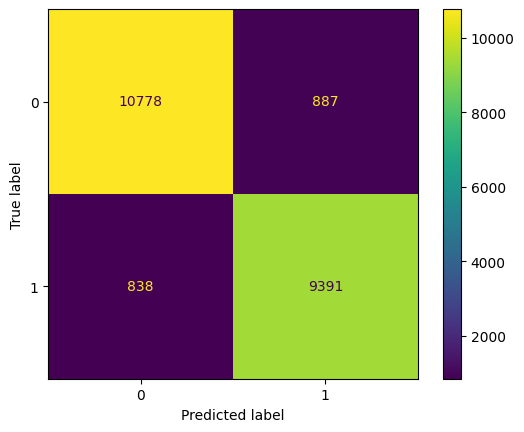

In [59]:
cm_pytorch = confusion_matrix(y_test_torch.cpu().numpy(), predicted.cpu().numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm_pytorch)
disp.plot()
plt.show()

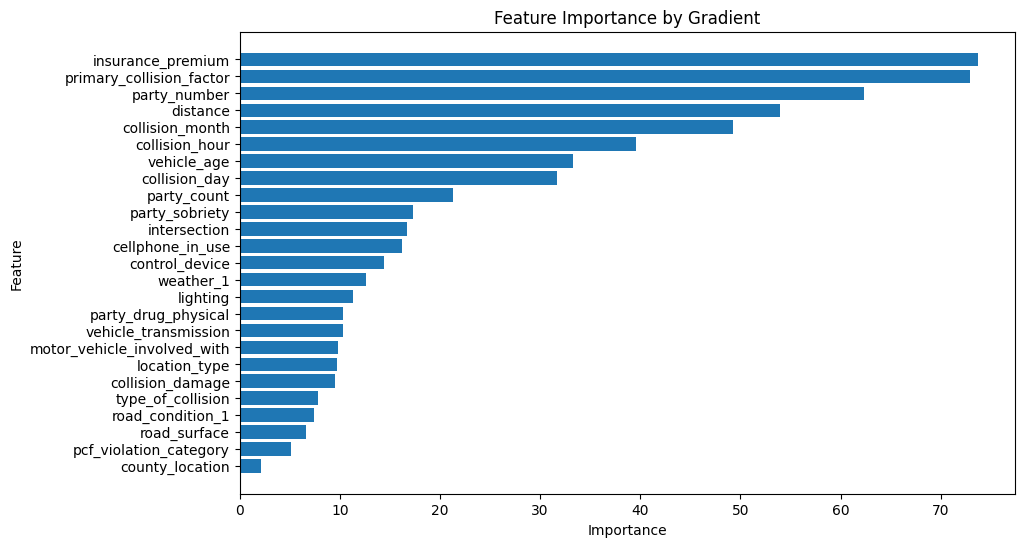

In [105]:
# Предположим, что final_model - это ваша обученная модель
# X_test_torch - это ваш тестовый набор данных

# Убедитесь, что модель находится в режиме оценки
final_model.eval()

# Включите автоградиент для входных данных
X_test_torch.requires_grad = True

# Прогоните данные через модель
outputs = final_model(X_test_torch.to(device))

# Предположим, что это задача бинарной классификации, и мы берем первый выход
# Если это многоклассовая классификация, выберите соответствующий выход
target_class = 0
target = outputs[:, target_class]

# Вычислите градиенты
target.backward(torch.ones_like(target))

# Получите абсолютные значения градиентов
feature_importance = X_test_torch.grad.abs().mean(dim=0).cpu().numpy()

# Отсортируем признаки по важности
sorted_idx = np.argsort(feature_importance)
sorted_feature_importance = feature_importance[sorted_idx]
sorted_feature_names = np.array(all_cols)[sorted_idx]

# Постройте перевернутый график важности признаков
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_feature_importance)), sorted_feature_importance, tick_label=sorted_feature_names)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance by Gradient')
plt.show()

### Написание градиентного бустинга с помощью LightGBM

#### Перебор гиперпараметров с помощью оптуны

In [60]:
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'n_jobs': -1,
        'feature_pre_filter': False,
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 200),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
    }

    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

    callbacks = [
        lgb.log_evaluation(100),
        lgb.callback.early_stopping(500, verbose=False)
    ]

    model = lgb.train(
        params,
        train_data,
        valid_sets=[train_data, test_data],
        num_boost_round=5000,
        callbacks=callbacks,
    )

    preds = model.predict(X_test)
    preds_binary = np.where(preds > 0.5, 1, 0)
    f1 = f1_score(y_test, preds_binary)

    print(f"\nTrial {trial.number} finished | Best F1: {f1:.4f}")
    print(f"Params: {params}\n")
    return f1


In [61]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print("Best trial:")
trial = study.best_trial
print(f"  F1: {trial.value:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-02-24 19:43:06,004] A new study created in memory with name: no-name-897a75d8-c476-4d71-b385-8cff95e60b39


[100]	training's binary_logloss: 0.214165	valid_1's binary_logloss: 0.242468
[200]	training's binary_logloss: 0.189116	valid_1's binary_logloss: 0.236359
[300]	training's binary_logloss: 0.173897	valid_1's binary_logloss: 0.235637
[400]	training's binary_logloss: 0.159699	valid_1's binary_logloss: 0.235141
[500]	training's binary_logloss: 0.147136	valid_1's binary_logloss: 0.235666
[600]	training's binary_logloss: 0.136151	valid_1's binary_logloss: 0.235612
[700]	training's binary_logloss: 0.126849	valid_1's binary_logloss: 0.23657
[800]	training's binary_logloss: 0.11777	valid_1's binary_logloss: 0.236727
[900]	training's binary_logloss: 0.109258	valid_1's binary_logloss: 0.237301


[I 2025-02-24 19:43:09,111] Trial 0 finished with value: 0.9144159433642051 and parameters: {'num_leaves': 197, 'learning_rate': 0.08856698305527859, 'max_depth': 11, 'min_child_samples': 113, 'subsample': 0.5833439091482706, 'colsample_bytree': 0.5077839220281302, 'reg_alpha': 8.100810417106573e-08, 'reg_lambda': 8.509847892198136}. Best is trial 0 with value: 0.9144159433642051.



Trial 0 finished | Best F1: 0.9144
Params: {'objective': 'binary', 'metric': 'binary_logloss', 'boosting_type': 'gbdt', 'verbosity': -1, 'n_jobs': -1, 'feature_pre_filter': False, 'num_leaves': 197, 'learning_rate': 0.08856698305527859, 'max_depth': 11, 'min_child_samples': 113, 'subsample': 0.5833439091482706, 'colsample_bytree': 0.5077839220281302, 'reg_alpha': 8.100810417106573e-08, 'reg_lambda': 8.509847892198136}

[100]	training's binary_logloss: 0.194786	valid_1's binary_logloss: 0.239692
[200]	training's binary_logloss: 0.164286	valid_1's binary_logloss: 0.237991
[300]	training's binary_logloss: 0.141364	valid_1's binary_logloss: 0.238016
[400]	training's binary_logloss: 0.122917	valid_1's binary_logloss: 0.238615
[500]	training's binary_logloss: 0.107842	valid_1's binary_logloss: 0.239309
[600]	training's binary_logloss: 0.0946217	valid_1's binary_logloss: 0.242025


[I 2025-02-24 19:43:10,498] Trial 1 finished with value: 0.9135958107059736 and parameters: {'num_leaves': 56, 'learning_rate': 0.19658163291850092, 'max_depth': 11, 'min_child_samples': 171, 'subsample': 0.783016075412464, 'colsample_bytree': 0.7967287989756537, 'reg_alpha': 0.035438102572643536, 'reg_lambda': 1.2196354401815e-05}. Best is trial 0 with value: 0.9144159433642051.


[700]	training's binary_logloss: 0.0835286	valid_1's binary_logloss: 0.244375

Trial 1 finished | Best F1: 0.9136
Params: {'objective': 'binary', 'metric': 'binary_logloss', 'boosting_type': 'gbdt', 'verbosity': -1, 'n_jobs': -1, 'feature_pre_filter': False, 'num_leaves': 56, 'learning_rate': 0.19658163291850092, 'max_depth': 11, 'min_child_samples': 171, 'subsample': 0.783016075412464, 'colsample_bytree': 0.7967287989756537, 'reg_alpha': 0.035438102572643536, 'reg_lambda': 1.2196354401815e-05}

[100]	training's binary_logloss: 0.49035	valid_1's binary_logloss: 0.492524
[200]	training's binary_logloss: 0.376672	valid_1's binary_logloss: 0.380631
[300]	training's binary_logloss: 0.319175	valid_1's binary_logloss: 0.324633
[400]	training's binary_logloss: 0.286585	valid_1's binary_logloss: 0.293408
[500]	training's binary_logloss: 0.267391	valid_1's binary_logloss: 0.275434
[600]	training's binary_logloss: 0.254282	valid_1's binary_logloss: 0.263592
[700]	training's binary_logloss: 0.245

[W 2025-02-24 19:43:12,851] Trial 2 failed with parameters: {'num_leaves': 51, 'learning_rate': 0.00645636193001719, 'max_depth': 9, 'min_child_samples': 144, 'subsample': 0.8627671532735677, 'colsample_bytree': 0.5482056715886954, 'reg_alpha': 6.115370085962932e-07, 'reg_lambda': 1.3519127360956209e-06} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/mnt/9ff244f6-7fea-487a-935b-91d4a4dbc13f/python_projects/carsharing-project/.venv/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_24315/1030533462.py", line 27, in objective
    model = lgb.train(
            ^^^^^^^^^^
  File "/mnt/9ff244f6-7fea-487a-935b-91d4a4dbc13f/python_projects/carsharing-project/.venv/lib/python3.12/site-packages/lightgbm/engine.py", line 322, in train
    booster.update(fobj=fobj)
  File "/mnt/9ff244f6-7fea-487a-935b-91d4a4dbc13f/python_projec

KeyboardInterrupt: 

#### Обучение на лучших гиперпараметрах модели градиентного бустинга

In [ ]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

best_params = trial.params
best_params.update({
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': -1,
    'n_jobs': -1
})

final_model = lgb.train(
    best_params,
    train_data,
    valid_sets=[test_data],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(50)]
)

# Оценка на тестовых данных
test_preds = final_model.predict(X_test)
test_preds_binary = np.where(test_preds > 0.5, 1, 0)
final_f1 = f1_score(y_test, test_preds_binary)
print(f"\nFinal Test F1: {final_f1:.4f}")

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.374548
[100]	valid_0's binary_logloss: 0.288645
[150]	valid_0's binary_logloss: 0.260902
[200]	valid_0's binary_logloss: 0.250474
[250]	valid_0's binary_logloss: 0.245223
[300]	valid_0's binary_logloss: 0.241539
[350]	valid_0's binary_logloss: 0.239187
[400]	valid_0's binary_logloss: 0.237992
[450]	valid_0's binary_logloss: 0.237217
[500]	valid_0's binary_logloss: 0.236419
[550]	valid_0's binary_logloss: 0.235783
[600]	valid_0's binary_logloss: 0.235394
[650]	valid_0's binary_logloss: 0.234945
[700]	valid_0's binary_logloss: 0.234539
[750]	valid_0's binary_logloss: 0.233974
[800]	valid_0's binary_logloss: 0.233681
[850]	valid_0's binary_logloss: 0.233239
[900]	valid_0's binary_logloss: 0.232909
[950]	valid_0's binary_logloss: 0.232628
[1000]	valid_0's binary_logloss: 0.23249
Did not meet early stopping. Best iteration is:
[988]	valid_0's binary_logloss: 0.232481

Final Test F1: 0.9144


#### Вывод по результату градиентного бустинга

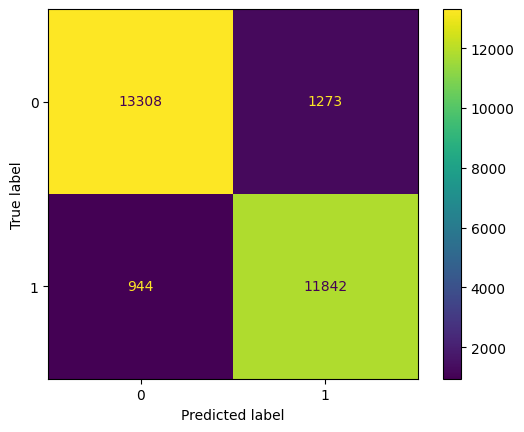

In [ ]:
cm_lgb = confusion_matrix(y_test, test_preds_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lgb)
disp.plot()
plt.show()

In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced', 'balanced_subsample'])
    }
    
    model = RandomForestClassifier(
        **params,
        random_state=42,
        n_jobs=-1
    )
    
    scores = cross_val_score(
        model,
        X_train,
        y_train,
        cv=3,
        scoring='f1_macro',
        n_jobs=-1
    )
    
    f1 = scores.mean()
    return f1

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=3600)

[I 2025-02-17 20:14:36,370] A new study created in memory with name: no-name-0f3e3a7a-16a6-4653-80a6-abbb81ae9e62
[I 2025-02-17 20:14:41,259] Trial 0 finished with value: 0.9178642542669717 and parameters: {'n_estimators': 234, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.9178642542669717.


Trial   0 | F1: 0.9179 | Params: {'n_estimators': 234, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': 'balanced_subsample'}


[I 2025-02-17 20:14:47,576] Trial 1 finished with value: 0.9160903437920856 and parameters: {'n_estimators': 174, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': None, 'bootstrap': False, 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.9178642542669717.
[I 2025-02-17 20:15:01,688] Trial 2 finished with value: 0.9135926332290856 and parameters: {'n_estimators': 232, 'max_depth': 12, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9178642542669717.
[I 2025-02-17 20:15:08,837] Trial 3 finished with value: 0.9133552464182312 and parameters: {'n_estimators': 463, 'max_depth': 9, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.9178642542669717.
[I 2025-02-17 20:15:11,241] Trial 4 finished with value: 0.9117814947430712 and paramet

Trial   5 | F1: 0.9102 | Params: {'n_estimators': 408, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': False, 'class_weight': 'balanced'}


[I 2025-02-17 20:15:41,290] Trial 6 finished with value: 0.9141164621204987 and parameters: {'n_estimators': 314, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': 'log2', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9178642542669717.
[I 2025-02-17 20:15:42,448] Trial 7 finished with value: 0.9104854718059778 and parameters: {'n_estimators': 97, 'max_depth': 5, 'min_samples_split': 13, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.9178642542669717.
[I 2025-02-17 20:15:50,484] Trial 8 finished with value: 0.9183544373961471 and parameters: {'n_estimators': 228, 'max_depth': 9, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 8 with value: 0.9183544373961471.
[I 2025-02-17 20:15:53,448] Trial 9 finished with value: 0.9133583684502685 and parameters: {'n_estimat

Trial  10 | F1: 0.9181 | Params: {'n_estimators': 343, 'max_depth': 8, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': None, 'bootstrap': True, 'class_weight': None}


[I 2025-02-17 20:16:16,078] Trial 11 finished with value: 0.9180791702466355 and parameters: {'n_estimators': 361, 'max_depth': 8, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 8 with value: 0.9183544373961471.
[I 2025-02-17 20:16:27,141] Trial 12 finished with value: 0.9180190430713521 and parameters: {'n_estimators': 375, 'max_depth': 7, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 8 with value: 0.9183544373961471.
[I 2025-02-17 20:16:32,111] Trial 13 finished with value: 0.9167056018309397 and parameters: {'n_estimators': 183, 'max_depth': 6, 'min_samples_split': 17, 'min_samples_leaf': 5, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 8 with value: 0.9183544373961471.
[I 2025-02-17 20:16:47,191] Trial 14 finished with value: 0.9181159523594776 and parameters: {'n_estimators': 468, 'max_depth'

Trial  15 | F1: 0.8978 | Params: {'n_estimators': 458, 'max_depth': 3, 'min_samples_split': 17, 'min_samples_leaf': 8, 'max_features': 'log2', 'bootstrap': True, 'class_weight': None}


[I 2025-02-17 20:17:10,350] Trial 16 finished with value: 0.9184633881141687 and parameters: {'n_estimators': 497, 'max_depth': 12, 'min_samples_split': 12, 'min_samples_leaf': 6, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 16 with value: 0.9184633881141687.
[I 2025-02-17 20:17:17,483] Trial 17 finished with value: 0.9185485204785341 and parameters: {'n_estimators': 175, 'max_depth': 12, 'min_samples_split': 11, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 17 with value: 0.9185485204785341.
[I 2025-02-17 20:17:19,036] Trial 18 finished with value: 0.9149177287067527 and parameters: {'n_estimators': 144, 'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True, 'class_weight': None}. Best is trial 17 with value: 0.9185485204785341.
[I 2025-02-17 20:17:23,054] Trial 19 finished with value: 0.9183012237685544 and parameters: {'n_estimators': 293, 'max

Trial  20 | F1: 0.9188 | Params: {'n_estimators': 126, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': True, 'class_weight': None}


[I 2025-02-17 20:17:33,980] Trial 21 finished with value: 0.9187935377350356 and parameters: {'n_estimators': 130, 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 20 with value: 0.9188300801051219.
[I 2025-02-17 20:17:39,633] Trial 22 finished with value: 0.9187931167957345 and parameters: {'n_estimators': 131, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 20 with value: 0.9188300801051219.
[I 2025-02-17 20:17:44,951] Trial 23 finished with value: 0.9190348561134613 and parameters: {'n_estimators': 118, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 23 with value: 0.9190348561134613.
[I 2025-02-17 20:17:47,713] Trial 24 finished with value: 0.9198213960938348 and parameters: {'n_estimators': 56, 'max_depth

Trial  25 | F1: 0.9197 | Params: {'n_estimators': 60, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': True, 'class_weight': None}


[I 2025-02-17 20:17:53,624] Trial 26 finished with value: 0.9202022752606327 and parameters: {'n_estimators': 62, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 26 with value: 0.9202022752606327.
[I 2025-02-17 20:17:57,048] Trial 27 finished with value: 0.920938934406589 and parameters: {'n_estimators': 70, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 27 with value: 0.920938934406589.
[I 2025-02-17 20:17:58,207] Trial 28 finished with value: 0.9191296472349264 and parameters: {'n_estimators': 61, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': 'balanced_subsample'}. Best is trial 27 with value: 0.920938934406589.
[I 2025-02-17 20:17:59,333] Trial 29 finished with value: 0.9166058274372347 and parameters: {'n_estimators': 84

Trial  30 | F1: 0.9189 | Params: {'n_estimators': 54, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': 'balanced_subsample'}


[I 2025-02-17 20:18:02,739] Trial 31 finished with value: 0.9197346319688678 and parameters: {'n_estimators': 51, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 27 with value: 0.920938934406589.
[I 2025-02-17 20:18:07,049] Trial 32 finished with value: 0.9194385269701547 and parameters: {'n_estimators': 95, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 27 with value: 0.920938934406589.
[I 2025-02-17 20:18:16,381] Trial 33 finished with value: 0.9202494339205156 and parameters: {'n_estimators': 206, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 27 with value: 0.920938934406589.
[I 2025-02-17 20:18:25,938] Trial 34 finished with value: 0.919733177705972 and parameters: {'n_estimators': 213, 'max_depth': 14

Trial  35 | F1: 0.9120 | Params: {'n_estimators': 151, 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': False, 'class_weight': 'balanced_subsample'}


[I 2025-02-17 20:18:43,239] Trial 36 finished with value: 0.9189762659379762 and parameters: {'n_estimators': 196, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 27 with value: 0.920938934406589.
[I 2025-02-17 20:18:50,557] Trial 37 finished with value: 0.9072582987385364 and parameters: {'n_estimators': 105, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 27 with value: 0.920938934406589.
[I 2025-02-17 20:18:57,335] Trial 38 finished with value: 0.9190631222074123 and parameters: {'n_estimators': 156, 'max_depth': 13, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 27 with value: 0.920938934406589.
[I 2025-02-17 20:19:01,069] Trial 39 finished with value: 0.9158248994968042 and parameters: {'n_estimators': 257, 'max_

Trial  40 | F1: 0.9194 | Params: {'n_estimators': 82, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': True, 'class_weight': 'balanced'}


[I 2025-02-17 20:19:07,181] Trial 41 finished with value: 0.9198326322021324 and parameters: {'n_estimators': 53, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 27 with value: 0.920938934406589.
[I 2025-02-17 20:19:11,055] Trial 42 finished with value: 0.920188458951373 and parameters: {'n_estimators': 80, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 27 with value: 0.920938934406589.
[I 2025-02-17 20:19:15,784] Trial 43 finished with value: 0.9196474087451149 and parameters: {'n_estimators': 105, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 27 with value: 0.920938934406589.
[I 2025-02-17 20:19:19,589] Trial 44 finished with value: 0.9201620941216867 and parameters: {'n_estimators': 82, 'max_depth': 14,

Trial  45 | F1: 0.9184 | Params: {'n_estimators': 83, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False, 'class_weight': None}


[I 2025-02-17 20:19:25,635] Trial 46 finished with value: 0.9191491703795064 and parameters: {'n_estimators': 108, 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 27 with value: 0.920938934406589.
[I 2025-02-17 20:19:32,015] Trial 47 finished with value: 0.9187810210953943 and parameters: {'n_estimators': 165, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 27 with value: 0.920938934406589.
[I 2025-02-17 20:19:35,688] Trial 48 finished with value: 0.9194740288535178 and parameters: {'n_estimators': 78, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 27 with value: 0.920938934406589.
[I 2025-02-17 20:19:45,539] Trial 49 finished with value: 0.9211327754998432 and parameters: {'n_estimators': 212, 'max_depth': 

In [ ]:
print("\nBest trial:")
trial = study.best_trial
print(f"  F1: {trial.value:.4f}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


Best trial:
  F1: 0.9211
  Params:
    n_estimators: 212
    max_depth: 15
    min_samples_split: 2
    min_samples_leaf: 1
    max_features: None
    bootstrap: True
    class_weight: None


In [ ]:
best_params = study.best_params
final_model = RandomForestClassifier(
    **best_params,
    random_state=42,
    n_jobs=-1
).fit(X_train, y_train)

# Оценка
test_preds = final_model.predict(X_test)
final_f1 = f1_score(y_test, test_preds, average='macro')
print(f"\nTest F1: {final_f1:.4f}")


Test F1: 0.9217


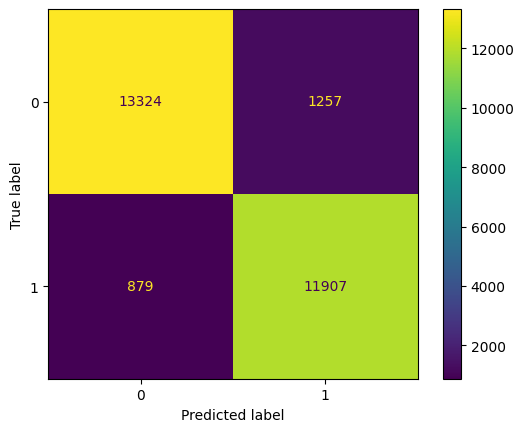

In [ ]:
cm_rfc = confusion_matrix(y_test, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rfc)
disp.plot()
plt.show()